In [1]:
import pandas as pd 
import numpy as np
from skimage import io, color, filters, feature
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
df=pd.read_csv('data/age_gender.csv')

In [4]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [6]:
type(df['pixels'][0])

str

In [7]:
df['pixels'][0][0:10]

'129 128 12'

In [8]:
df['pixels']=df['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

In [9]:
X = np.array(df['pixels'].tolist())

## Converting pixels from 1D to 3D
X = X.reshape(X.shape[0],48,48)

In [10]:
X.shape

(23705, 48, 48)

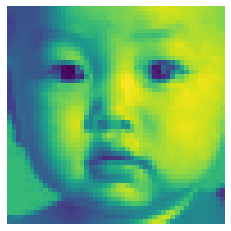

In [11]:
plt.imshow(X[2].reshape(48,48))
plt.axis('off')
plt.show()

__Ethnicity is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).__

In [12]:
df['gender_str']=df['gender'].map({1:'Female',0:'Male'})
df['ethnicity_str']=df['ethnicity'].map({0:'White',1:'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'})

In [13]:
np.random.randint(0, len(X), 1)[0]

9353

In [14]:
np.array(df['age'])

array([ 1,  1,  1, ..., 99, 99, 99])

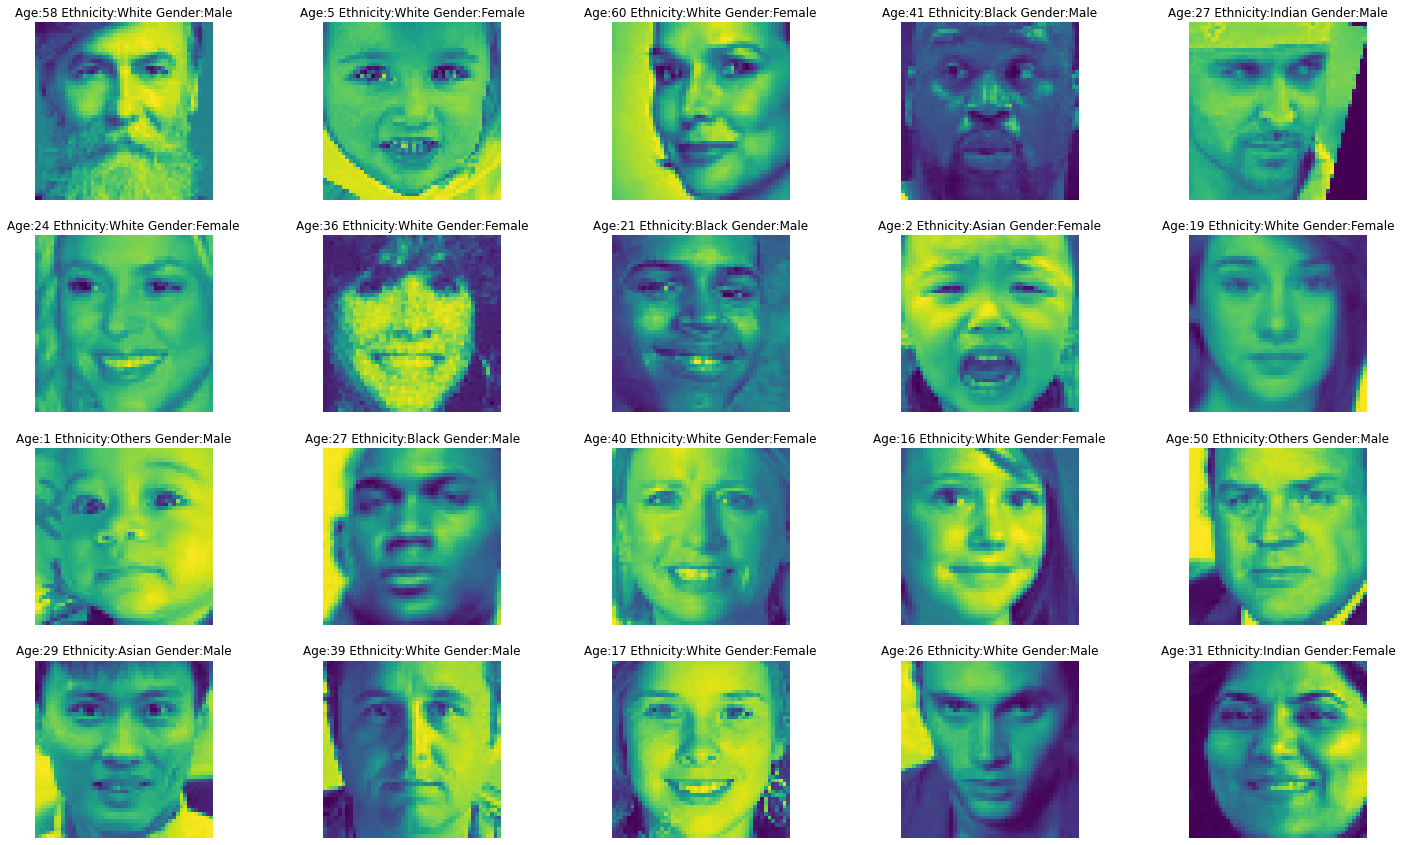

In [15]:
fig, axes = plt.subplots(4,5, figsize=(25,15))
# rand_number=np.random.randint(0, len(X), 20)
for ax in axes.flat:
    i=np.random.randint(0, len(X), 1)
    ax.imshow(X[i][0])
    ax.set_title(
 "Age:"+str(np.array(df['age'])[i][0])+" Ethnicity:"+str(np.array(df['ethnicity_str'])[i][0])+" Gender:"+str(np.array(df['gender_str'])[i][0])    )
    ax.axis('off')
plt.show()

In [16]:
df['age'].value_counts()

26     2197
1      1123
28      918
35      880
24      859
       ... 
115       3
101       2
91        2
103       1
111       1
Name: age, Length: 104, dtype: int64

# EDA

## __Age__

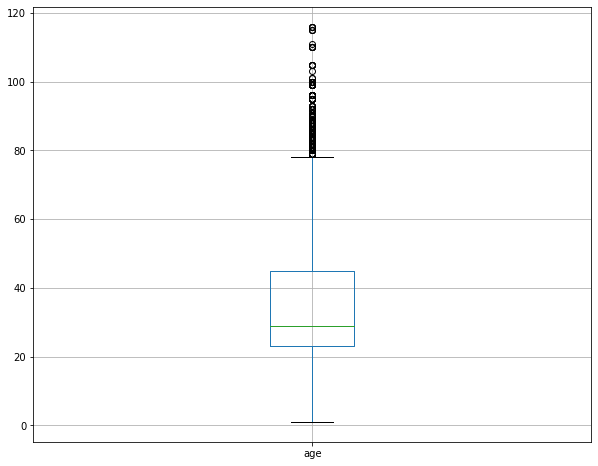

In [17]:
df[['age']].boxplot(figsize=(10,8));

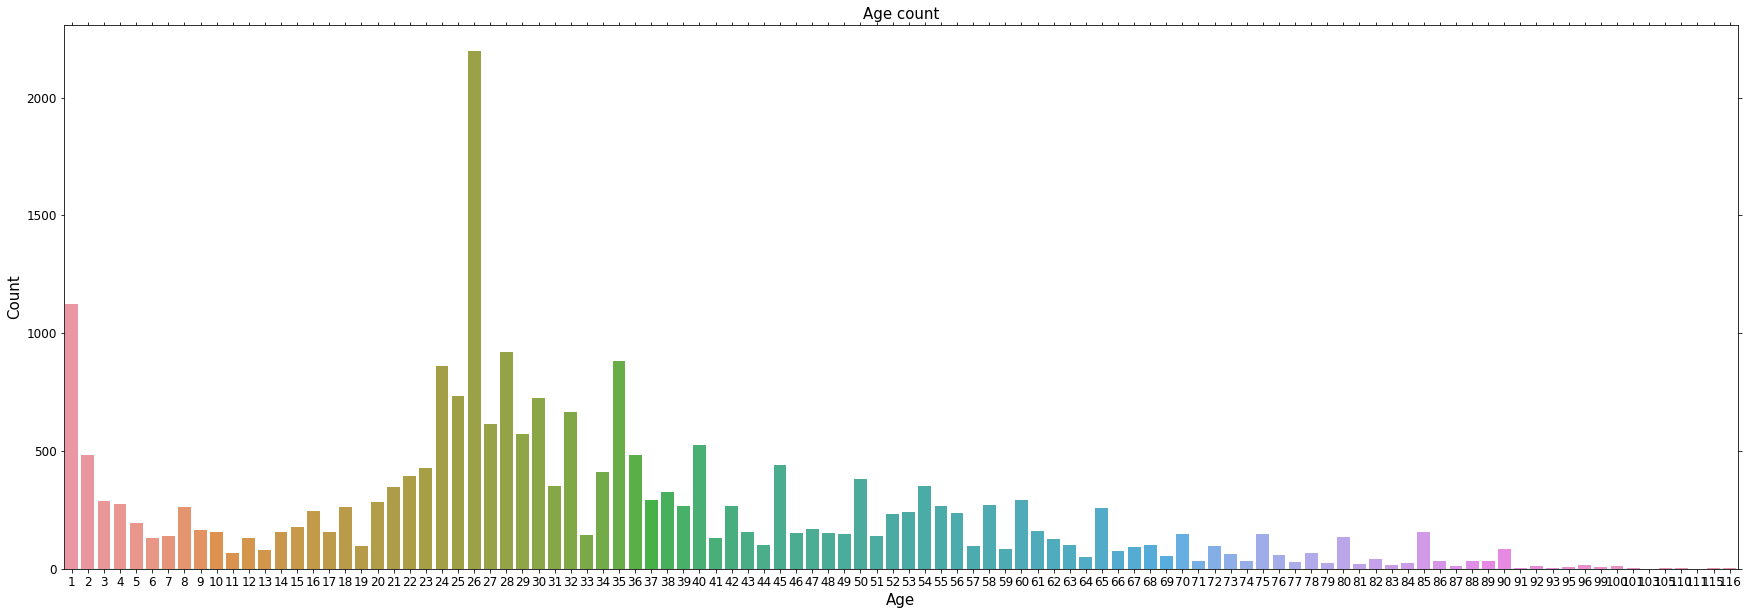

In [18]:
plt.figure(figsize=(30,10))
ax=sns.countplot(df['age'])
ax.set_title("Age count", size=15)
ax.set_xlabel("Age", size=15)
ax.set_ylabel("Count", size=15)
ax.tick_params(labelsize=12, reset= True)

## __Gender__

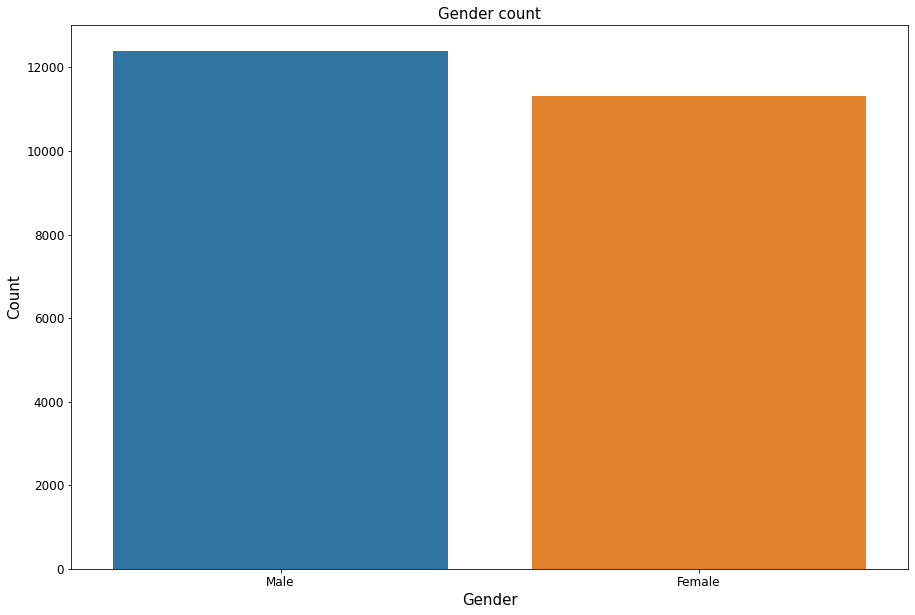

In [19]:
plt.figure(figsize=(15,10))
ax=sns.countplot(df['gender_str'])
ax.set_title("Gender count", size=15)
ax.set_xlabel("Gender", size=15)
ax.set_ylabel("Count", size=15)
ax.tick_params(labelsize=12);

## __Ethnicity__

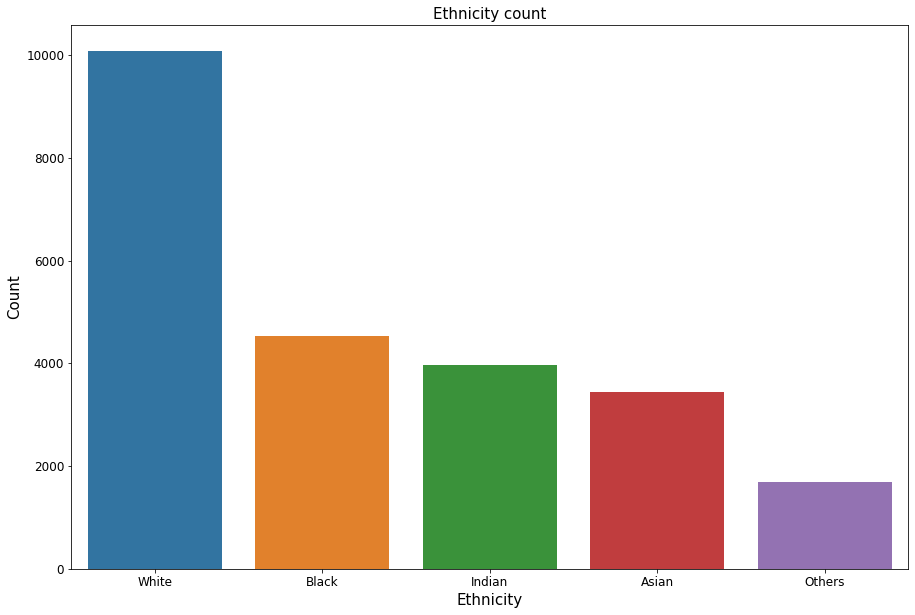

In [20]:
plt.figure(figsize=(15,10))
ax=sns.countplot(df['ethnicity_str'], order=df['ethnicity_str'].value_counts().index)
ax.set_title("Ethnicity count", size=15)
ax.set_xlabel("Ethnicity", size=15)
ax.set_ylabel("Count", size=15)
ax.tick_params(labelsize=12);

In [21]:
X.shape

(23705, 48, 48)

In [22]:
y_gender=np.array(df.gender)
y_gender.shape
y_ethnicity=np.array(df.ethnicity)
y_ethnicity.shape
y_age=np.array(df.age)
y_age.shape

(23705,)

### __Model Building__

#### __Gender Model__

In [23]:
import tensorflow as tf
import tensorflow.keras.layers as L

In [24]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [25]:
X=X.reshape(X.shape[0],48,48,1)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_gender, test_size=0.25, random_state=37)

In [303]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [348]:
def build_model(num_classes, activation='softmax', loss='sparse_categorical_crossentropy', kernel_size=(3,3)):
    x = tf.keras.models.Sequential()
    inputs = tf.keras.Input(shape=(48, 48, 1))
    
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
    x = tf.keras.layers.Conv2D(64, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation=activation)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    
    model.compile(
        optimizer='adam',
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [155]:
gender_model = build_model(1, activation='sigmoid', loss='binary_crossentropy',kernel_size=(3,3))

In [193]:
gender_model.summary()

Model: "functional_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        [(None, 48, 48, 1)]       0         
_________________________________________________________________
rescaling_39 (Rescaling)     (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 48, 48, 64)        640       
_________________________________________________________________
max_pooling2d_135 (MaxPoolin (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_136 (MaxPoolin (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 12, 12, 64)      

In [156]:
gender_history = gender_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=8,
    epochs=10,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()],
    verbose=1
)

Epoch 1/10
2223/2223 [==============================] - 7s 3ms/step - loss: 0.4560 - accuracy: 0.7791 - val_loss: 0.3399 - val_accuracy: 0.8465
Epoch 2/10
2223/2223 [==============================] - 6s 3ms/step - loss: 0.3263 - accuracy: 0.8559 - val_loss: 0.3127 - val_accuracy: 0.8557
Epoch 3/10
2223/2223 [==============================] - 7s 3ms/step - loss: 0.2923 - accuracy: 0.8697 - val_loss: 0.2889 - val_accuracy: 0.8743
Epoch 4/10
2223/2223 [==============================] - 6s 3ms/step - loss: 0.2713 - accuracy: 0.8818 - val_loss: 0.2824 - val_accuracy: 0.8713
Epoch 5/10
2223/2223 [==============================] - 7s 3ms/step - loss: 0.2565 - accuracy: 0.8898 - val_loss: 0.2862 - val_accuracy: 0.8696
Epoch 6/10
2223/2223 [==============================] - 6s 3ms/step - loss: 0.2400 - accuracy: 0.8966 - val_loss: 0.2718 - val_accuracy: 0.8773
Epoch 7/10
2223/2223 [==============================] - 6s 3ms/step - loss: 0.2289 - accuracy: 0.9021 - val_loss: 0.2773 - val_accuracy:

In [47]:
#gender_history.history

In [28]:
score = model.evaluate(X_test, y_test, verbose=0)

In [163]:
gender_model2 = build_model(2, activation='sigmoid', loss='sparse_categorical_crossentropy',kernel_size=(3,3))
gender_model2.fit(
  X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=8,
    epochs=10,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()],
    verbose=1)

Epoch 1/10
2223/2223 [==============================] - 7s 3ms/step - loss: 0.4614 - accuracy: 0.7723 - val_loss: 0.4237 - val_accuracy: 0.8443
Epoch 2/10
2223/2223 [==============================] - 6s 3ms/step - loss: 0.3179 - accuracy: 0.8616 - val_loss: 0.3047 - val_accuracy: 0.8657
Epoch 3/10
2223/2223 [==============================] - 7s 3ms/step - loss: 0.2817 - accuracy: 0.8755 - val_loss: 0.2866 - val_accuracy: 0.8687
Epoch 4/10
2223/2223 [==============================] - 6s 3ms/step - loss: 0.2643 - accuracy: 0.8836 - val_loss: 0.2715 - val_accuracy: 0.8811
Epoch 5/10
2223/2223 [==============================] - 6s 3ms/step - loss: 0.2448 - accuracy: 0.8964 - val_loss: 0.2824 - val_accuracy: 0.8797
Epoch 6/10
2223/2223 [==============================] - 6s 3ms/step - loss: 0.2275 - accuracy: 0.9036 - val_loss: 0.2616 - val_accuracy: 0.8843
Epoch 7/10
2223/2223 [==============================] - 6s 3ms/step - loss: 0.2190 - accuracy: 0.9078 - val_loss: 0.2553 - val_accuracy:

In [34]:
X_train.shape

(17778, 48, 48, 1)

In [36]:
y_pred=gender_model.predict(X_test)

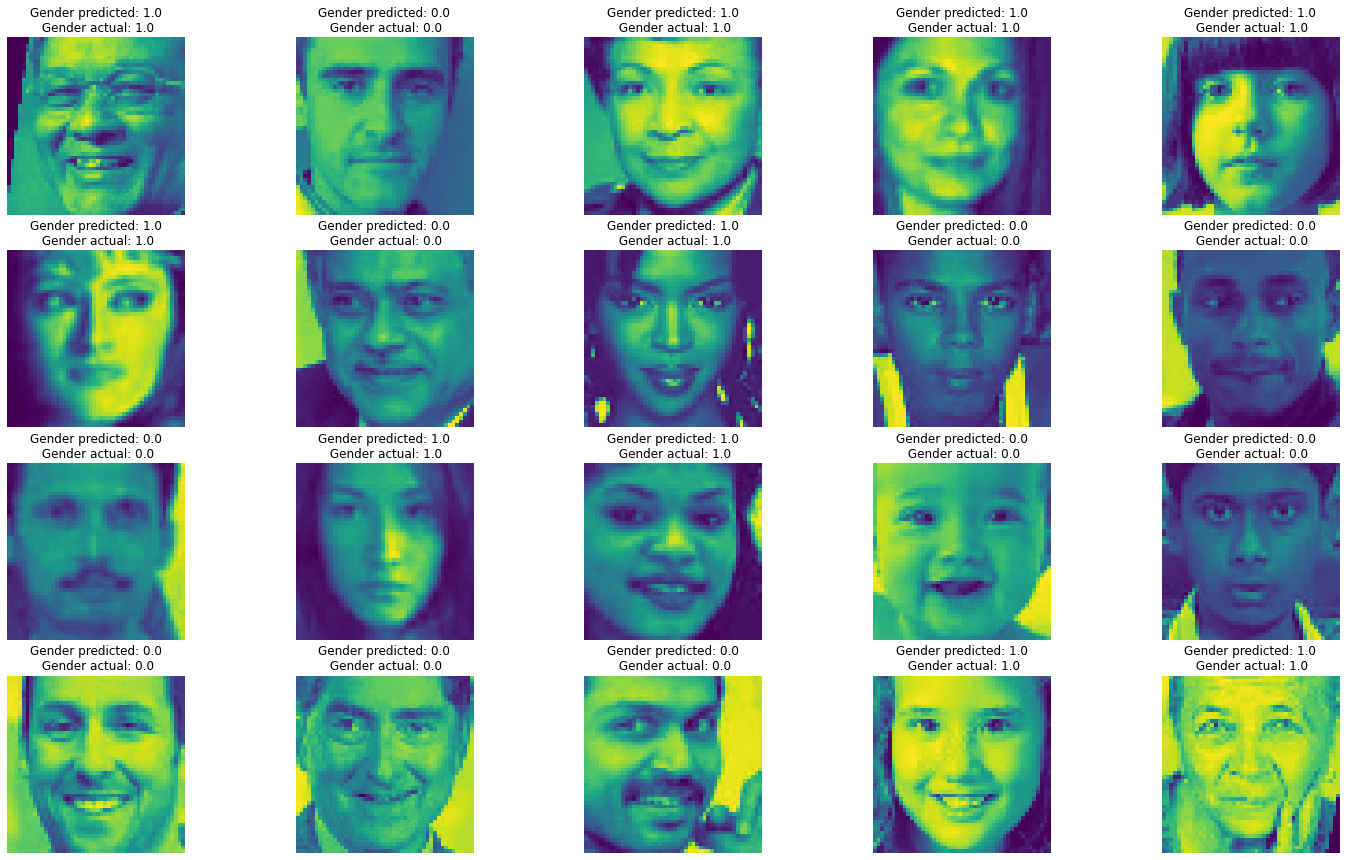

In [48]:
fig, axes = plt.subplots(4,5, figsize=(25,15))
# rand_number=np.random.randint(0, len(X), 20)
for ax in axes.flat:
    i=np.random.randint(0, len(y_test),1)
    X_plot=X_test[i].reshape(48,48)
    
    #print(X_plot.shape)
    ax.imshow(X_plot)
    ax.set_title( "Gender predicted: "+str(round(y_pred[i][0][0]))+ "\n Gender actual: "+str(round(y_pred[i][0][0] )))
    #ax.set_title( )
    ax.axis('off')
plt.show()

#### __Ethnicity Model__

In [165]:
X_ethnicity_train, X_ethnicity_test, y_ethnicity_train, y_ethnicity_test = train_test_split(
    X, y_ethnicity, test_size=0.25, random_state=37)

Have created a function for ethno model.

In [370]:
def build_ethno_model(num_classes, activation='softmax', loss='sparse_categorical_crossentropy', kernel_size=(3,3)):
    model = tf.keras.models.Sequential()
    input_shape = (48,48,1)
    #conv 1
    model.add(tf.keras.layers.Conv2D(16, input_shape=input_shape,activation='relu', kernel_size=3, padding='same'))# strides=4
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    # conv 2
    model.add(tf.keras.layers.Conv2D(32, activation='relu', kernel_size=3, padding='same'))# strides=4
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    #conv 3
    model.add(tf.keras.layers.Conv2D(64, activation='relu', kernel_size=3, padding='same'))# strides=4
    #conv 4  
    model.add(tf.keras.layers.Conv2D(128, activation='relu', kernel_size=3, padding='same'))# strides=4
    # conv 5
    model.add(tf.keras.layers.Conv2D(256, activation='relu', kernel_size=3, padding='same'))# strides=4
    
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1024))
    model.add(tf.keras.layers.Activation('relu'))

    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.Activation('relu'))
    

    
    model.add(tf.keras.layers.Dropout(0.5))   
    model.add(tf.keras.layers.Dense(num_classes))
    model.add(tf.keras.layers.Activation(activation))
    model.compile(loss=loss, metrics=['accuracy'],optimizer='rmsprop') # optimizer='rmsprop'
    return model

In [366]:
ethno_model_test = build_ethno_model(5,loss='sparse_categorical_crossentropy')

In [367]:
ethno_model_test.summary()

Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_350 (Conv2D)          (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d_289 (MaxPoolin (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_351 (Conv2D)          (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_290 (MaxPoolin (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_352 (Conv2D)          (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_353 (Conv2D)          (None, 12, 12, 128)       73856     
_________________________________________________________________
conv2d_354 (Conv2D)          (None, 12, 12, 256)     

In [371]:
history_ethnicity=ethnicity_model.fit(X_ethnicity_train,y_ethnicity_train, verbose=1,     
                                       validation_data=(X_ethnicity_test, y_ethnicity_test),
    batch_size=8,
    epochs=20,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()] )

Epoch 1/20
2223/2223 [==============================] - 7s 3ms/step - loss: 0.4373 - accuracy: 0.8414 - val_loss: 0.9896 - val_accuracy: 0.7518
Epoch 2/20
2223/2223 [==============================] - 6s 3ms/step - loss: 0.2482 - accuracy: 0.9093 - val_loss: 1.0698 - val_accuracy: 0.7525
Epoch 3/20
2223/2223 [==============================] - 6s 3ms/step - loss: 0.2092 - accuracy: 0.9251 - val_loss: 1.2857 - val_accuracy: 0.7602
Epoch 4/20
2223/2223 [==============================] - 6s 3ms/step - loss: 0.1875 - accuracy: 0.9314 - val_loss: 1.2896 - val_accuracy: 0.7552
Epoch 5/20
2223/2223 [==============================] - 6s 3ms/step - loss: 0.1757 - accuracy: 0.9392 - val_loss: 1.2229 - val_accuracy: 0.7489
Epoch 6/20
2223/2223 [==============================] - 6s 3ms/step - loss: 0.1647 - accuracy: 0.9417 - val_loss: 1.2409 - val_accuracy: 0.7528
Epoch 7/20
2223/2223 [==============================] - 5s 2ms/step - loss: 0.1542 - accuracy: 0.9467 - val_loss: 1.2767 - val_accuracy: